### Transformers
...

<img src="doc/transformer_cross_attention.png" alt="Transformer Cross Attention" width="500">

---

### Example 1: learning modulo function using transformer
...

---

100%|██████████| 50000/50000 [06:38<00:00, 125.41it/s]


Input sequence: tensor([[ 6,  8, 10]])
True label: tensor([6])
Predicted class: tensor([6])


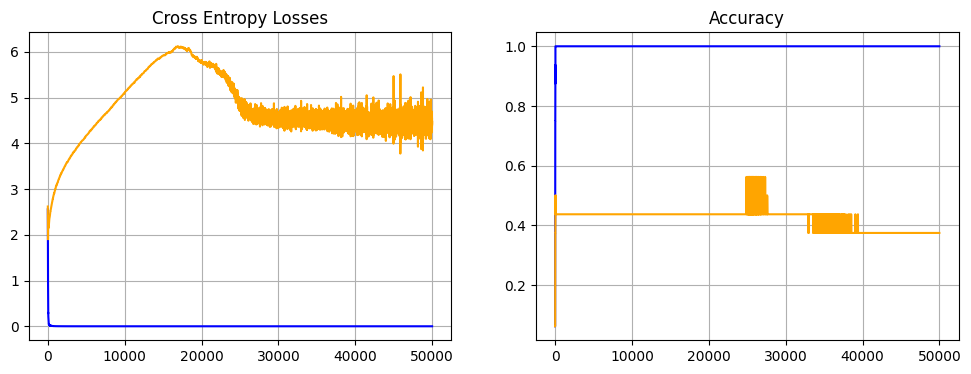

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

# ----------------------------
# Parameters
# ----------------------------
# Vocabulary
VOCAB_SIZE = 10 + 1
SEP_TOKEN = VOCAB_SIZE - 1
MAX_LEN = 3                 # [a, b, SEP]
# Model
EMBEDDING_SIZE = 64
NUM_HEADS = 4
NUM_LAYERS = 2
# Hyperparameters
BATCH_SIZE = 16
EPOCHS = 50000
LR = 3e-4
DEVICE = "cpu"

# ----------------------------
# Dataset
# ----------------------------
def generate_batch(batch_size):
    a = torch.randint(0, VOCAB_SIZE - 1, (batch_size,))
    b = torch.randint(1, VOCAB_SIZE - 1, (batch_size,))
    y = a % b
    x = torch.stack([a, b, torch.full_like(a, SEP_TOKEN)], dim=1)
    return x.to(DEVICE), y.to(DEVICE)

# ----------------------------
# Multi-Head Self Attention
# ----------------------------
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, num_embedding, num_heads):
        super().__init__()
        assert num_embedding % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = num_embedding // num_heads
        self.qkv = nn.Linear(num_embedding, 3 * num_embedding)
        self.out = nn.Linear(num_embedding, num_embedding)

    def forward(self, x):
        # x.shape = (batch size, sequence length, embedding size)
        B, T, C = x.shape
        # Calculate key, value, query tensors
        qkv = self.qkv(x)   # (batch size, sequence length, 3 * embedding size)
        qkv = qkv.reshape(B, T, 3, self.num_heads, self.head_dim)   # (batch size, sequence length, 3, number heads, head dimensions)
        qkv = qkv.permute(2, 0, 3, 1, 4)    # (3, batch size, number heads, sequence length, head dimensions)
        q, k, v = qkv[0], qkv[1], qkv[2]    # for each -> (batch size, number heads, sequence length, head dimensions)
        # Scaled dot product attention
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)   # (batch size, number heads, sequence length, sequence length)
        attn = torch.softmax(scores, dim=-1)   # (batch size, number heads, sequence length, sequence length)
        # Output
        out = attn @ v  # (batch size, number heads, sequence length, head dimensions)
        out = out.transpose(1, 2).reshape(B, T, C)  # (batch size, sequence length, embedding size)
        out = self.out(out)  # (batch size, sequence length, embedding size)
        return out

# ----------------------------
# Transformer Block
# ----------------------------
class TransformerBlock(nn.Module):
    def __init__(self, num_embedding, num_heads, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.ln_1 = nn.LayerNorm(num_embedding)
        self.attn = MultiHeadSelfAttention(num_embedding, num_heads)
        self.ln_2 = nn.LayerNorm(num_embedding)
        self.mlp = nn.Sequential(
            nn.Linear(num_embedding, mlp_ratio * num_embedding),
            nn.GELU(),
            nn.Linear(mlp_ratio * num_embedding, num_embedding),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # x.shape = (batch size, sequence length, embedding size)
        x = x + self.attn(self.ln_1(x)) # (batch size, sequence length, embedding size)
        x = x + self.mlp(self.ln_2(x))  # (batch size, sequence length, embedding size)
        return x

# ----------------------------
# Full Transformer Model
# ----------------------------
class TransformerModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_emb = nn.Embedding(VOCAB_SIZE, EMBEDDING_SIZE)
        self.pos_emb = nn.Embedding(MAX_LEN, EMBEDDING_SIZE)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(EMBEDDING_SIZE, NUM_HEADS)
            for _ in range(NUM_LAYERS)
        ])
        self.norm = nn.LayerNorm(EMBEDDING_SIZE)
        self.head = nn.Linear(EMBEDDING_SIZE, VOCAB_SIZE)

    def forward(self, x):
        # x.shape = (batch size, sequence length)
        _, T = x.shape
        # Embeddings
        positions = torch.arange(T, device=DEVICE)
        x = self.token_emb(x) + self.pos_emb(positions) # (batch size, sequence length, embedding size)
        # Transformer
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)    # (batch size, sequence length, embedding size)
        # Normalization
        x = self.norm(x)    # (batch size, sequence length, embedding size)
        # Use first token representation for classification
        out = self.head(x[:, 0, :])
        return out

# ----------------------------
# Training
# ----------------------------
model = TransformerModel().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
x_train, y_train = generate_batch(BATCH_SIZE)
x_val, y_val = generate_batch(BATCH_SIZE)
losses_train_list, losses_val_list = [], []
acc_train_list, acc_val_list = [], []
for epoch in tqdm(range(EPOCHS)):
    # -------------------- Train --------------------
    model.train()
    logits_train = model(x_train)
    loss_train = F.cross_entropy(logits_train, y_train)
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    losses_train_list.append(loss_train.item())
    # Training accuracy
    preds_train = logits_train.argmax(dim=-1)
    acc_train = (preds_train == y_train).float().mean().item()
    acc_train_list.append(acc_train)

    # -------------------- Eval --------------------
    model.eval()
    with torch.no_grad():
        logits_val = model(x_val)
        loss_val = F.cross_entropy(logits_val, y_val)
        losses_val_list.append(loss_val.item())
        # Evaluation accuracy
        preds_val = logits_val.argmax(dim=-1)
        acc_val = (preds_val == y_val).float().mean().item()
        acc_val_list.append(acc_val)

# ----------------------------
# Manuel eval
# ----------------------------
# Generate one sample
x_val, y_val = generate_batch(1)  # shape: (1, 3)
logits_val = model(x_val)         # shape: (1, VOCAB_SIZE)
# Convert logits to probabilities
probs = F.softmax(logits_val, dim=-1)
# Predicted class
pred_class = probs.argmax(dim=-1)
# Print
print("Input sequence:", x_val)
print("True label:", y_val)
# print("Predicted logits:", logits_val)
# print("Predicted probabilities:", probs)
print("Predicted class:", pred_class)

# ----------------------------
# Plotting
# ----------------------------
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title("Cross Entropy Losses")
plt.plot(losses_train_list, color="blue")
plt.plot(losses_val_list, color="orange")
plt.grid()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(acc_train_list, color="blue")
plt.plot(acc_val_list, color="orange")
plt.grid()
